Diffusers实战

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision

In [2]:
def show_images(x):
    x = x*0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1,2,0).clip(0,1)*255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images, size=64):
    output_im = Image.new('RGB',(size*len(images),size))
    for i,im in enumerate(images):
        output_im.paste(im.resize((size,size)),(i*size,0))
    return output_im

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

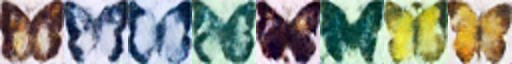

In [9]:
'''调用预设API，生成蝴蝶图片'''
from diffusers import DDPMPipeline

butterfly_pipeline = DDPMPipeline.from_pretrained('johnowhitaker/ddpm-butterflies-32px').to(device)

images = butterfly_pipeline(batch_size=8).images

make_grid(images)

下面逐步构建训练模型，生成蝴蝶图像。

In [3]:
'''下载蝴蝶图像集'''
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset('huggan/smithsonian_butterflies_subset',split='train')
image_size = 32
batch_size = 32

#数据增强
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

def transform(examples):
    images = [preprocess(image.convert('RGB')) for image in examples['image']]
    return {'images':images}

dataset.set_transform(transform)

#创建数据加载器
train_dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

C:\Users\bao'bao'mao\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


X shape: torch.Size([8, 3, 32, 32])


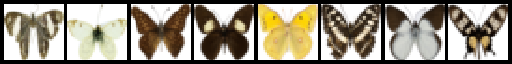

In [4]:
#提取一批图像，可视化
xb = next(iter(train_dataloader))['images'].to(device)[:8]
print('X shape:',xb.shape)
show_images(xb).resize((8*64,64),resample=Image.NEAREST)

Noise X shape torch.Size([8, 3, 32, 32])


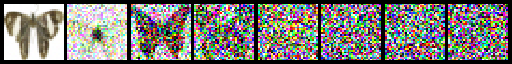

In [5]:
'''扩散模型调度器,用于加噪去噪'''
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000) #,beta_schedule='squaredcos_cap_v2' 适合小尺寸
                                                          # ,beta_start=0.001,beta_end=0.004 少量噪声
timesteps = torch.linspace(0,999,8).long().to(device)
noise = torch.randn_like(xb)
noise_xb = noise_scheduler.add_noise(xb,noise,timesteps)
print('Noise X shape',noise_xb.shape)
show_images(noise_xb).resize((8*64,64),resample=Image.NEAREST)

In [6]:
'''创建基于UNet网络的扩散模型'''
from diffusers import UNet2DModel

#create model
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2, #unet块使用的resnet层数
    block_out_channels=(64,128,128,256),
    down_block_types=( #下采样
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'AttnDownBlock2D',
    ),
    up_block_types=( #上采样
        'AttnUpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
    )
)
model.to(device)

with torch.no_grad():#检测输入输出尺寸是否相同
    model_prediction = model(noise_xb,timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In [ ]:
'''创建扩散模型训练循环'''
#噪声调度器
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2'
)

#训练循环
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch['images'].to(device)
        #加噪
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        #每张图片 随机采样一时间步
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,),
            device=clean_images.device
        ).long()

        #根据每个时间步的噪声，向图片加噪
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        #模型的预测
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        #计算损失
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        #迭代参数
        optimizer.step()
        optimizer.zero_grad()
        
    if (epoch+1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):])/len(train_dataloader)
        print(f'Epoch:{epoch+1},loss:{loss_last_epoch}')

#绘制损失曲线
fig, axs = plt.subplot(1,2,figsize=(12,4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [10]:
'''上面模型训练较慢，可以用下面代码直接使用管线中的模型'''
model = butterfly_pipeline.unet

In [ ]:
'''图像生成，写一个采样循环'''
sample = torch.rand(8,3,32,32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    #获得模型预测结果
    with torch.no_grad():
        residual = model(sample, t).sample
    
    #根据预测更新图像
    sample = noise_scheduler.step(residual, t, sample).prev_sample

    if t%100 == 0:
        show_images(sample)
show_images(sample)